# Data Actually
David Robinson posted a great article [Analyzing networks of characters in 'Love Actually'](http://varianceexplained.org/r/love-actually-network) on 25th December 2015, which uses [R](http://www.r-project.org) to analyse the connections between the characters in the film [Love Actually](http://www.imdb.com/title/tt0314331).

This notebook and the [associated python code](https://github.com/mattmcd/PyAnalysis/blob/master/scripts/love_actually/love_actually.py) attempts to reproduce his analysis using tools from the Python ecosystem.  The code in this notebook is copied from love_actually.py as of 29th December 2015 (ideally I'd keep them in sync but no promises)

## Package setup
To start we need to import some useful packages, shown below.  Some of these needed to be installed using the [Anaconda distribution](https://www.continuum.io/why-anaconda) or pip if conda failed:

- pip install ggplot
- conda install graphviz
- conda install networkx
- conda install pyplot

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import dendrogram, linkage
import ggplot as gg
import networkx as nx

In [2]:
%matplotlib inline

## Data import
First we need to define a couple of functions to read the 'Love Actually' script into a list of lines and the cast into a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).  The data_dir variable gets the location of the directory containing the input files from an environment variable so set this environment variable to the location appropriate for you if you're following along.

In [3]:
data_dir = os.path.join(os.getenv('MDA_DATA_DIR', '/home/mattmcd/Work/Data'), 'LoveActually')

def read_script():
    """Read the Love Actually script from text file into list of lines
    The script is first Google hit for 'Love Actually script' as a doc
    file.  Use catdoc or Libre Office to save to text format.
    """
    with open(os.path.join(data_dir, 'love_actually.txt'), 'r') as f:
        lines = [line.strip() for line in f]
    return lines

def read_actors():
    """Read the mapping from character to actor using the varianceexplained data file
    Used curl -O http://varianceexplained.org/files/love_actually_cast.csv to get a local copy
    """
    return pd.read_csv(os.path.join(data_dir, 'love_actually_cast.csv'))

The cell below reproduces the logic in the first cell of the original article.  It doesn't feel quite as nice to me as the [dplyr syntax](https://cran.rstudio.com/web/packages/dplyr/vignettes/introduction.html) but is not too bad.

In [4]:
def parse_script(raw):
    df = pd.DataFrame(raw, columns=['raw'])

    df = df.query('raw != ""')
    df = df[~df.raw.str.contains("(song)")]
    lines = (df.
             assign(is_scene=lambda d: d.raw.str.contains(" Scene ")).
             assign(scene=lambda d: d.is_scene.cumsum()).
             query('not is_scene'))
    speakers = lines.raw.str.extract('(?P<speaker>[^:]*):(?P<dialogue>.*)')
    lines = (pd.concat([lines, speakers], axis=1).
             dropna().
             assign(line=lambda d: np.cumsum(~d.speaker.isnull())))

    lines.drop(['raw', 'is_scene'], axis=1, inplace=True)

    return lines

In [5]:
def read_all():
    lines = parse_script(read_script())
    cast = read_actors()
    combined = lines.merge(cast).sort('line').assign(
        character=lambda d: d.speaker + ' (' + d.actor + ')').reindex()
    # Decode bytes to unicode
    combined['character'] = map(lambda s: s.decode('utf-8'), combined['character'])
    return combined

In [6]:
# Read in script and cast into a dataframe
lines = read_all()
# Print the first few rows
lines.head(10)

/home/mattmcd/anaconda/lib/python2.7/site-packages/pandas/core/strings.py:207: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  " groups, use str.extract.", UserWarning)


,scene,speaker,dialogue,line,actor,character
0,2,Billy,♪ I feel it in my fingers ♪ I feel it in my t...,2,Bill Nighy,Billy (Bill Nighy)
36,2,Joe,"I'm afraid you did it again, Bill.",3,Gregor Fisher,Joe (Gregor Fisher)
1,2,Billy,"It's just I know the old version so well, you...",4,Bill Nighy,Billy (Bill Nighy)
37,2,Joe,"Well, we all do. That's why we're making the ...",5,Gregor Fisher,Joe (Gregor Fisher)
2,2,Billy,"Right, OK, let's go. ♪ I feel it in my finger...",6,Bill Nighy,Billy (Bill Nighy)
3,2,Billy,"Oh, fuck, wank, bugger, shitting, arsehead an...",7,Bill Nighy,Billy (Bill Nighy)
4,2,Billy,"This is shit, isn't it?",8,Bill Nighy,Billy (Bill Nighy)
38,2,Joe,"Yup, solid gold shit, Maestro.",9,Gregor Fisher,Joe (Gregor Fisher)
51,3,Jamie,"God, I'm so late.",10,Colin Firth,Jamie (Colin Firth)
52,3,Jamie,You sure you don't mind me going without you?,12,Colin Firth,Jamie (Colin Firth)


Constructing the n_character x n_scene matrix showing how many lines each character has in each scene is quite easy using pandas groupby method to create a hierarchical index, followed by the unstack method to convert the second level of the index into columns.

In [7]:
def get_scene_speaker_matrix(lines):
    by_speaker_scene = lines.groupby(['character', 'scene'])['line'].count()
    speaker_scene_matrix = by_speaker_scene.unstack().fillna(0)
    return by_speaker_scene, speaker_scene_matrix

In [8]:
# Group by speaker and scene and construct the speaker-scene matrix
by_speaker_scene, speaker_scene_matrix = get_scene_speaker_matrix(lines)

## Analysis
Now we get to the analysis itself.  First we perform a hierarchical clustering of the data using the same data normalization and clustering method as the original article.  The leaf order in the dendrogram is returned for use in later steps of the analysis, as it has similar characters close to each other.

In [9]:
def plot_dendrogram(mat, normalize=True):
    # Cluster and plot dendrogram.  Return order after clustering.
    if normalize:
        # Normalize by number of lines
        mat = mat.div(mat.sum(axis=1), axis=0)
    Z = linkage(mat, method='complete', metric='cityblock')
    labels = mat.index
    f = plt.figure()
    ax = f.add_subplot(111)
    R = dendrogram(Z, leaf_rotation=90, leaf_font_size=8,
               labels=labels, ax=ax, color_threshold=-1)
    f.tight_layout()
    ordering = R['ivl']
    return ordering

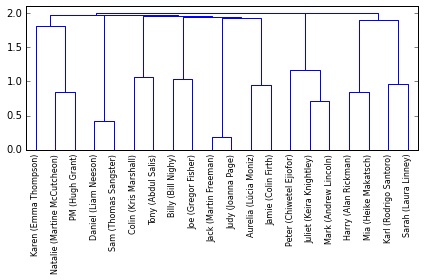

In [10]:
# Hierarchical cluster and return order of leaves
ordering = plot_dendrogram(speaker_scene_matrix)

In [11]:
print(ordering)

[u'Karen (Emma Thompson)', u'Natalie (Martine McCutcheon)', u'PM (Hugh Grant)', u'Daniel (Liam Neeson)', u'Sam (Thomas Sangster)', u'Colin (Kris Marshall)', u'Tony (Abdul Salis)', u'Billy (Bill Nighy)', u'Joe (Gregor Fisher)', u'Jack (Martin Freeman)', u'Judy (Joanna Page)', u'Aurelia (L\xfacia Moniz)', u'Jamie (Colin Firth)', u'Peter (Chiwetel Ejiofor)', u'Juliet (Keira Knightley)', u'Mark (Andrew Lincoln)', u'Harry (Alan Rickman)', u'Mia (Heike Makatsch)', u'Karl (Rodrigo Santoro)', u'Sarah (Laura Linney)']


### Timeline
Plotting the timeline of character versus scene is very similar to the R version since we make use of the [Python ggplot port from yhat](http://ggplot.yhathq.com/).  It seems like there are a few differences between this package and the [R ggplot2 library](http://ggplot2.org/).  

In particular:

- ggplot does not seem to handle categorical variables so it was necessary to introduce an extra character_code dimension
- it didn't seem possible to change the y-axis tick labels to character names so here the axis directions are swapped
- the aes (aesthetic) does not seem to support 'group' so the geom_path joining characters in the same scene has been left out

(note that these points may just be limitations of my understanding of ggplot in Python)

In [12]:
def get_scenes_with_multiple_characters(by_speaker_scene):
    # Filter speaker scene dataframe to remove scenes with only one speaker

    # n_scene x 1 Series with index 'scene'
    filt = by_speaker_scene.count('scene') > 1
    # n_scene x n_character Index
    scene_index = by_speaker_scene.index.get_level_values('scene')
    # n_scene x n_character boolean vector
    ind = filt[scene_index].values
    return by_speaker_scene[ind]

In [13]:
def order_scenes(scenes, ordering=None):
    # Order scenes by e.g. leaf order after hierarchical clustering
    scenes = scenes.reset_index()
    scenes['scene'] = scenes['scene'].astype('category')
    scenes['character'] = scenes['character'].astype('category', categories=ordering)
    scenes['character_code'] = scenes['character'].cat.codes
    return scenes

In [14]:
# Order the scenes by cluster leaves order
scenes = order_scenes(get_scenes_with_multiple_characters(by_speaker_scene), ordering)

In [15]:
def plot_timeline(scenes):
    # Plot character vs scene timelime
    # NB: due to limitations in Python ggplot we need to plot with scene on y-axis
    # in order to label x-ticks by character.
    # scale_x_continuous and scale_y_continuous behave slightly differently.

    print (gg.ggplot(gg.aes(y='scene', x='character_code'), data=scenes) +
            gg.geom_point() + gg.labs(x='Character', y='Scene') +
           gg.scale_x_continuous(
               labels=scenes['character'].cat.categories.values.tolist(),
           breaks=range(len(scenes['character'].cat.categories))) +
           gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, size=10)))

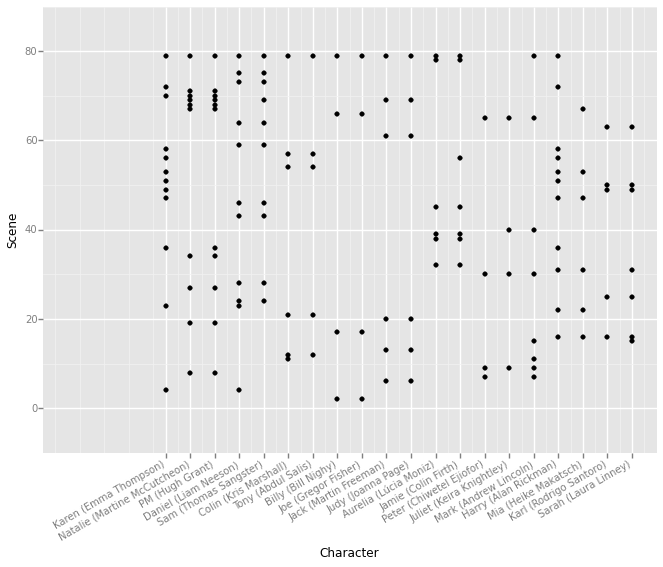

<ggplot: (8778114035989)>


In [16]:
# Plot a timeline of characters vs scene
plot_timeline(scenes);

### Co-occurrence matrix
Next we construct the co-occurrence matrix showing how often characters share scenes, and visualize using a heatmap and network graph.

In [17]:
def get_cooccurrence_matrix(speaker_scene_matrix, ordering=None):
    # Co-occurrence matrix for the characters, ignoring last scene where all are present
    scene_ind = speaker_scene_matrix.astype(bool).sum() < 10
    if ordering:
        mat = speaker_scene_matrix.loc[ordering, scene_ind]
    else:
        mat = speaker_scene_matrix.loc[:, scene_ind]
    return mat.dot(mat.T)

In [18]:
cooccur_mat = get_cooccurrence_matrix(speaker_scene_matrix, ordering)

The heatmap below is not as nice as the default R heatmap as it is missing the dendrograms on each axis and also the character names, so could be extended e.g. following [Hierarchical Clustering Heatmaps in Python](http://altanalyze.blogspot.co.uk/2012/06/hierarchical-clustering-heatmaps-in.html).  

It otherwise shows a similar result to the original article in that ordering using the dendrogram leaf order has resulted in a co-occurrence matrix predominantly of block diagonal form.

In [19]:
def plot_heatmap(cooccur_mat):
    # Plot co-ccurrence matrix as heatmap
    plt.figure()
    plt.pcolor(cooccur_mat)

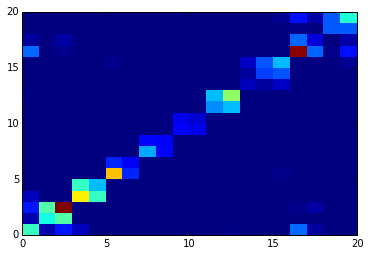

In [20]:
# Plot heatmap of co-occurrence matrix
plot_heatmap(cooccur_mat)

The network plot gives similar results to the original article.  This could be extended, for example by adding weights to the graph edges.

In [21]:
def plot_network(cooccur_mat):
    # Plot co-occurence matrix as network diagram
    G = nx.Graph(cooccur_mat.values)
    pos = nx.graphviz_layout(G)  # NB: needs pydot installed
    plt.figure()
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='c')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(
        G, pos,
        labels={i: s for (i, s) in enumerate(cooccur_mat.index.values)},
        font_size=10)
    plt.axis('off')
    plt.show()

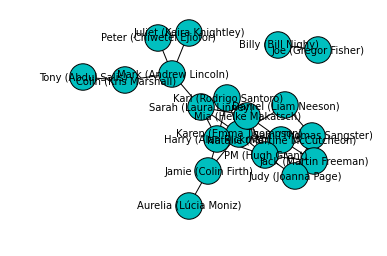

In [22]:
# Plot network graph of co-occurrence matrix
plot_network(cooccur_mat)

## Conclusion
This notebook attempted to reproduce using Python the R analysis and visualization of the character network in 'Love Actually'.  Overall this was a useful exercise in learning similarities and differences between the tools, as well as becoming more familiar with the Pandas syntax.  The output currently doesn't look quite as nice as the R original but is a good starting point for future tinkering.

#### About Me
I am [Matt McDonnell](https://www.matt-mcdonnell.com) and am currently working as a Data Scientist for a Cambridge (UK) based startup.  Previously my main language has been [MATLAB](http://www.mathworks.com) used in quantitative analyst and quantitative developer roles for a London based asset management firm, as well as in a Technical Consultant role for MathWorks.  In my current role the main languages used are R, Python and SQL, with Clojure being the main language used outside the Data Science team.  

[Twitter](http://twitter.com/mattmcd)